#### Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from catboost import CatBoostClassifier, Pool 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix


#### Read in Dataset

In [2]:
dogs = pd.read_csv('../data/dogs.csv', parse_dates=['intake_datetime'])

In [3]:
dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70917 entries, 0 to 70916
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   animal_id             70917 non-null  object        
 1   intake_datetime       70917 non-null  datetime64[ns]
 2   name                  58825 non-null  object        
 3   intake_type           70917 non-null  object        
 4   intake_condition      70917 non-null  object        
 5   animal_type           70917 non-null  object        
 6   intake_sex            70916 non-null  object        
 7   intake_spay_neuter    70916 non-null  object        
 8   intake_age_in_years   70917 non-null  float64       
 9   age_group             70917 non-null  object        
 10  breed                 70917 non-null  object        
 11  breed_1               70917 non-null  object        
 12  breed_2               11609 non-null  object        
 13  mix_flag        

#### Feature Selection

In [4]:
dogs['intake_year'] = dogs['intake_datetime'].dt.year.astype('object')
dogs['intake_month'] = dogs['intake_datetime'].dt.month.astype('object')

In [5]:
target_map = {
    'Adoption':'Other',
    'Return to Owner':'Return to Owner',
    'Transfer':'Other',
    'Euthanasia':'Other',
    'Rto-Adopt':'Other',
    'Died':'Other',
    'Missing':'Other',
    'Disposal':'Other'
}

dogs['outcome_type'] = dogs['outcome_type'].map(target_map)

In [6]:
dogs = dogs.dropna(subset=['outcome_type', 'intake_sex'])

In [7]:
dogs = dogs[
            (dogs['intake_condition'] == 'Normal') &
            (dogs['intake_type'] == 'Stray')
           ]

In [8]:
features = [
    'intake_year',
    'intake_month',
    'intake_spay_neuter',
    'intake_age_in_years',
    'breed'
]

target = ['outcome_type']

In [9]:
X = dogs[features]
y = dogs[target]

#### CatBoost Category Columns

In [10]:
#CatBoost requires the specification of categorical columns. This function gets the list of categorical indicies

def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

categorical_indicies = get_categorical_indicies(X)

In [11]:
categorical_indicies

[0, 1, 2, 4]

In [12]:
#CatBoost needs the categorical columns to be converted to the categorical datatype

def convert_cats(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        X[col] = X[col].astype('category')

convert_cats(X)

<ipython-input-12-6025a30c5164>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


#### Train, Test, Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=63)

#### SMOTE

In [14]:
oversampler = SMOTENC(k_neighbors=5, n_jobs=-1, random_state=63, categorical_features=categorical_indicies)

In [15]:
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)

#### Pool

In [16]:
train_dataset = Pool(X_smote, 
                     y_smote,
                     cat_features=categorical_indicies
                    )
test_dataset = Pool(X_test, 
                    y_test,
                    cat_features=categorical_indicies
                   )

#### Model Training and Prediction

In [17]:
clf = CatBoostClassifier(loss_function='Logloss', eval_metric='F1')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100, 150]}

clf.grid_search(grid, train_dataset)

preds = clf.predict(X_test)

print(preds)

0:	learn: 0.6355146	test: 0.6381717	best: 0.6381717 (0)	total: 75.9ms	remaining: 3.72s
1:	learn: 0.6602639	test: 0.6604204	best: 0.6604204 (1)	total: 87.3ms	remaining: 2.1s
2:	learn: 0.6602836	test: 0.6604204	best: 0.6604204 (1)	total: 96.6ms	remaining: 1.51s
3:	learn: 0.6638563	test: 0.6638034	best: 0.6638034 (3)	total: 106ms	remaining: 1.22s
4:	learn: 0.6631441	test: 0.6637083	best: 0.6638034 (3)	total: 114ms	remaining: 1.02s
5:	learn: 0.6640618	test: 0.6644295	best: 0.6644295 (5)	total: 123ms	remaining: 899ms
6:	learn: 0.6633436	test: 0.6637083	best: 0.6644295 (5)	total: 133ms	remaining: 816ms
7:	learn: 0.6635430	test: 0.6637083	best: 0.6644295 (5)	total: 145ms	remaining: 761ms
8:	learn: 0.6642011	test: 0.6644295	best: 0.6644295 (5)	total: 156ms	remaining: 710ms
9:	learn: 0.6644203	test: 0.6644295	best: 0.6644295 (5)	total: 164ms	remaining: 655ms
10:	learn: 0.6644203	test: 0.6644295	best: 0.6644295 (5)	total: 173ms	remaining: 612ms
11:	learn: 0.6768685	test: 0.6766417	best: 0.676641

7:	learn: 0.6964329	test: 0.6945232	best: 0.6945232 (7)	total: 73.4ms	remaining: 385ms
8:	learn: 0.6964927	test: 0.6948101	best: 0.6948101 (8)	total: 85.2ms	remaining: 388ms
9:	learn: 0.6963823	test: 0.6951604	best: 0.6951604 (9)	total: 101ms	remaining: 402ms
10:	learn: 0.6834020	test: 0.6781975	best: 0.6951604 (9)	total: 113ms	remaining: 400ms
11:	learn: 0.6832095	test: 0.6777499	best: 0.6951604 (9)	total: 128ms	remaining: 405ms
12:	learn: 0.6830992	test: 0.6776803	best: 0.6951604 (9)	total: 144ms	remaining: 409ms
13:	learn: 0.6830992	test: 0.6776803	best: 0.6951604 (9)	total: 157ms	remaining: 403ms
14:	learn: 0.6830992	test: 0.6779120	best: 0.6951604 (9)	total: 169ms	remaining: 394ms
15:	learn: 0.6934484	test: 0.6921804	best: 0.6951604 (9)	total: 178ms	remaining: 377ms
16:	learn: 0.6929271	test: 0.6885246	best: 0.6951604 (9)	total: 187ms	remaining: 362ms
17:	learn: 0.6929271	test: 0.6885246	best: 0.6951604 (9)	total: 196ms	remaining: 348ms
18:	learn: 0.6954160	test: 0.6900056	best: 0

1:	learn: 0.6602639	test: 0.6604204	best: 0.6604204 (1)	total: 21.3ms	remaining: 512ms
2:	learn: 0.6691921	test: 0.6687913	best: 0.6687913 (2)	total: 33.4ms	remaining: 524ms
3:	learn: 0.6667255	test: 0.6664302	best: 0.6687913 (2)	total: 43.6ms	remaining: 502ms
4:	learn: 0.6679017	test: 0.6675331	best: 0.6687913 (2)	total: 50.9ms	remaining: 458ms
5:	learn: 0.6685925	test: 0.6682476	best: 0.6687913 (2)	total: 58.9ms	remaining: 432ms
6:	learn: 0.6687102	test: 0.6682476	best: 0.6687913 (2)	total: 66.4ms	remaining: 408ms
7:	learn: 0.6686122	test: 0.6682476	best: 0.6687913 (2)	total: 75.4ms	remaining: 396ms
8:	learn: 0.6784293	test: 0.6773434	best: 0.6773434 (8)	total: 84.8ms	remaining: 386ms
9:	learn: 0.6840548	test: 0.6815124	best: 0.6815124 (9)	total: 94.6ms	remaining: 379ms
10:	learn: 0.6900377	test: 0.6869947	best: 0.6869947 (10)	total: 104ms	remaining: 367ms
11:	learn: 0.6900377	test: 0.6869947	best: 0.6869947 (10)	total: 113ms	remaining: 357ms
12:	learn: 0.6900752	test: 0.6869947	best

9:	learn: 0.6644203	test: 0.6644295	best: 0.6644295 (5)	total: 132ms	remaining: 1.19s
10:	learn: 0.6644203	test: 0.6644295	best: 0.6644295 (5)	total: 151ms	remaining: 1.22s
11:	learn: 0.6768685	test: 0.6766417	best: 0.6766417 (11)	total: 161ms	remaining: 1.18s
12:	learn: 0.6766931	test: 0.6764846	best: 0.6766417 (11)	total: 169ms	remaining: 1.13s
13:	learn: 0.6766931	test: 0.6765649	best: 0.6766417 (11)	total: 176ms	remaining: 1.08s
14:	learn: 0.6774422	test: 0.6763973	best: 0.6766417 (11)	total: 184ms	remaining: 1.04s
15:	learn: 0.6772861	test: 0.6762402	best: 0.6766417 (11)	total: 191ms	remaining: 1s
16:	learn: 0.6959857	test: 0.6905273	best: 0.6905273 (16)	total: 202ms	remaining: 984ms
17:	learn: 0.6954573	test: 0.6900836	best: 0.6905273 (16)	total: 211ms	remaining: 960ms
18:	learn: 0.6961122	test: 0.6906751	best: 0.6906751 (18)	total: 219ms	remaining: 933ms
19:	learn: 0.6961147	test: 0.6906751	best: 0.6906751 (18)	total: 228ms	remaining: 913ms
20:	learn: 0.6962411	test: 0.6906751	b

12:	learn: 0.7068702	test: 0.7073007	best: 0.7075524 (11)	total: 195ms	remaining: 1.31s
13:	learn: 0.7025299	test: 0.7047662	best: 0.7075524 (11)	total: 210ms	remaining: 1.29s
14:	learn: 0.7022215	test: 0.7037665	best: 0.7075524 (11)	total: 227ms	remaining: 1.28s
15:	learn: 0.7018215	test: 0.7037247	best: 0.7075524 (11)	total: 245ms	remaining: 1.28s
16:	learn: 0.7101329	test: 0.7110963	best: 0.7110963 (16)	total: 260ms	remaining: 1.27s
17:	learn: 0.7180969	test: 0.7159956	best: 0.7159956 (17)	total: 275ms	remaining: 1.25s
18:	learn: 0.7178588	test: 0.7166975	best: 0.7166975 (18)	total: 294ms	remaining: 1.25s
19:	learn: 0.7203590	test: 0.7168381	best: 0.7168381 (19)	total: 320ms	remaining: 1.28s
20:	learn: 0.7253010	test: 0.7203690	best: 0.7203690 (20)	total: 344ms	remaining: 1.29s
21:	learn: 0.7266746	test: 0.7210724	best: 0.7210724 (21)	total: 360ms	remaining: 1.28s
22:	learn: 0.7327017	test: 0.7270811	best: 0.7270811 (22)	total: 374ms	remaining: 1.25s
23:	learn: 0.7380603	test: 0.734

19:	learn: 0.6951821	test: 0.6896396	best: 0.6951604 (9)	total: 175ms	remaining: 699ms
20:	learn: 0.6934964	test: 0.6885801	best: 0.6951604 (9)	total: 188ms	remaining: 708ms
21:	learn: 0.6938261	test: 0.6890244	best: 0.6951604 (9)	total: 203ms	remaining: 719ms
22:	learn: 0.6943020	test: 0.6891724	best: 0.6951604 (9)	total: 222ms	remaining: 745ms
23:	learn: 0.6949969	test: 0.6897641	best: 0.6951604 (9)	total: 244ms	remaining: 773ms
24:	learn: 0.6951390	test: 0.6904011	best: 0.6951604 (9)	total: 259ms	remaining: 778ms
25:	learn: 0.6948141	test: 0.6896163	best: 0.6951604 (9)	total: 289ms	remaining: 822ms
26:	learn: 0.7085323	test: 0.7070729	best: 0.7070729 (26)	total: 315ms	remaining: 853ms
27:	learn: 0.6996293	test: 0.6943727	best: 0.7070729 (26)	total: 339ms	remaining: 871ms
28:	learn: 0.7082758	test: 0.7068475	best: 0.7070729 (26)	total: 356ms	remaining: 872ms
29:	learn: 0.7103185	test: 0.7078822	best: 0.7078822 (29)	total: 373ms	remaining: 870ms
30:	learn: 0.7109544	test: 0.7096427	be

12:	learn: 0.7037306	test: 0.7055780	best: 0.7055780 (12)	total: 171ms	remaining: 1.15s
13:	learn: 0.7029709	test: 0.7050197	best: 0.7055780 (12)	total: 180ms	remaining: 1.1s
14:	learn: 0.7062271	test: 0.7089603	best: 0.7089603 (14)	total: 197ms	remaining: 1.12s
15:	learn: 0.7060073	test: 0.7086189	best: 0.7089603 (14)	total: 209ms	remaining: 1.09s
16:	learn: 0.7202224	test: 0.7201391	best: 0.7201391 (16)	total: 222ms	remaining: 1.08s
17:	learn: 0.7202978	test: 0.7198262	best: 0.7201391 (16)	total: 231ms	remaining: 1.05s
18:	learn: 0.7212842	test: 0.7204243	best: 0.7204243 (18)	total: 240ms	remaining: 1.02s
19:	learn: 0.7213766	test: 0.7211518	best: 0.7211518 (19)	total: 255ms	remaining: 1.02s
20:	learn: 0.7214004	test: 0.7212298	best: 0.7212298 (20)	total: 266ms	remaining: 1s
21:	learn: 0.7341215	test: 0.7342116	best: 0.7342116 (21)	total: 277ms	remaining: 981ms
22:	learn: 0.7357198	test: 0.7356801	best: 0.7356801 (22)	total: 289ms	remaining: 967ms
23:	learn: 0.7363814	test: 0.7362065

13:	learn: 0.6904299	test: 0.6872979	best: 0.6872979 (13)	total: 124ms	remaining: 762ms
14:	learn: 0.6853884	test: 0.6834642	best: 0.6872979 (13)	total: 140ms	remaining: 793ms
15:	learn: 0.6850639	test: 0.6832356	best: 0.6872979 (13)	total: 156ms	remaining: 817ms
16:	learn: 0.6853684	test: 0.6834642	best: 0.6872979 (13)	total: 165ms	remaining: 808ms
17:	learn: 0.6854250	test: 0.6834642	best: 0.6872979 (13)	total: 175ms	remaining: 797ms
18:	learn: 0.6858838	test: 0.6840811	best: 0.6872979 (13)	total: 184ms	remaining: 786ms
19:	learn: 0.6858439	test: 0.6840811	best: 0.6872979 (13)	total: 192ms	remaining: 768ms
20:	learn: 0.6912311	test: 0.6881274	best: 0.6881274 (20)	total: 201ms	remaining: 755ms
21:	learn: 0.6912311	test: 0.6881274	best: 0.6881274 (20)	total: 210ms	remaining: 744ms
22:	learn: 0.6818561	test: 0.6794425	best: 0.6881274 (20)	total: 219ms	remaining: 735ms
23:	learn: 0.6819489	test: 0.6794425	best: 0.6881274 (20)	total: 229ms	remaining: 724ms
24:	learn: 0.6815318	test: 0.678

14:	learn: 0.6992628	test: 0.7004776	best: 0.7004776 (14)	total: 192ms	remaining: 1.09s
15:	learn: 0.7050022	test: 0.7043420	best: 0.7043420 (15)	total: 206ms	remaining: 1.08s
16:	learn: 0.7055484	test: 0.7061844	best: 0.7061844 (16)	total: 221ms	remaining: 1.08s
17:	learn: 0.7266806	test: 0.7244865	best: 0.7244865 (17)	total: 231ms	remaining: 1.05s
18:	learn: 0.7266225	test: 0.7247364	best: 0.7247364 (18)	total: 241ms	remaining: 1.02s
19:	learn: 0.7269410	test: 0.7230377	best: 0.7247364 (18)	total: 249ms	remaining: 997ms
20:	learn: 0.7295471	test: 0.7267140	best: 0.7267140 (20)	total: 260ms	remaining: 977ms
21:	learn: 0.7390271	test: 0.7363000	best: 0.7363000 (21)	total: 269ms	remaining: 953ms
22:	learn: 0.7385485	test: 0.7359818	best: 0.7363000 (21)	total: 278ms	remaining: 932ms
23:	learn: 0.7378846	test: 0.7354344	best: 0.7363000 (21)	total: 286ms	remaining: 906ms
24:	learn: 0.7390938	test: 0.7365602	best: 0.7365602 (24)	total: 295ms	remaining: 886ms
25:	learn: 0.7393813	test: 0.736

26:	learn: 0.7015578	test: 0.6958282	best: 0.6958282 (24)	total: 259ms	remaining: 1.18s
27:	learn: 0.7016762	test: 0.6956424	best: 0.6958282 (24)	total: 273ms	remaining: 1.19s
28:	learn: 0.7023988	test: 0.6963745	best: 0.6963745 (28)	total: 285ms	remaining: 1.19s
29:	learn: 0.7023988	test: 0.6963745	best: 0.6963745 (28)	total: 295ms	remaining: 1.18s
30:	learn: 0.7022799	test: 0.6964526	best: 0.6964526 (30)	total: 302ms	remaining: 1.16s
31:	learn: 0.7076010	test: 0.7044516	best: 0.7044516 (31)	total: 310ms	remaining: 1.14s
32:	learn: 0.7088439	test: 0.7057903	best: 0.7057903 (32)	total: 317ms	remaining: 1.12s
33:	learn: 0.7103425	test: 0.7089959	best: 0.7089959 (33)	total: 324ms	remaining: 1.11s
34:	learn: 0.7104549	test: 0.7094549	best: 0.7094549 (34)	total: 331ms	remaining: 1.09s
35:	learn: 0.7102032	test: 0.7091030	best: 0.7094549 (34)	total: 339ms	remaining: 1.07s
36:	learn: 0.7100388	test: 0.7089735	best: 0.7094549 (34)	total: 346ms	remaining: 1.06s
37:	learn: 0.7097311	test: 0.708

119:	learn: 0.7442963	test: 0.7402143	best: 0.7406797 (114)	total: 1.06s	remaining: 265ms
120:	learn: 0.7443473	test: 0.7402143	best: 0.7406797 (114)	total: 1.07s	remaining: 258ms
121:	learn: 0.7442133	test: 0.7402905	best: 0.7406797 (114)	total: 1.08s	remaining: 248ms
122:	learn: 0.7443994	test: 0.7406034	best: 0.7406797 (114)	total: 1.09s	remaining: 240ms
123:	learn: 0.7445084	test: 0.7406797	best: 0.7406797 (114)	total: 1.1s	remaining: 231ms
124:	learn: 0.7444634	test: 0.7405500	best: 0.7406797 (114)	total: 1.11s	remaining: 222ms
125:	learn: 0.7445773	test: 0.7403668	best: 0.7406797 (114)	total: 1.12s	remaining: 213ms
126:	learn: 0.7446413	test: 0.7403668	best: 0.7406797 (114)	total: 1.13s	remaining: 204ms
127:	learn: 0.7446792	test: 0.7405194	best: 0.7406797 (114)	total: 1.14s	remaining: 195ms
128:	learn: 0.7447112	test: 0.7405194	best: 0.7406797 (114)	total: 1.15s	remaining: 187ms
129:	learn: 0.7447492	test: 0.7404887	best: 0.7406797 (114)	total: 1.16s	remaining: 178ms
130:	learn:

80:	learn: 0.7485769	test: 0.7442006	best: 0.7445923 (78)	total: 722ms	remaining: 615ms
81:	learn: 0.7486284	test: 0.7444086	best: 0.7445923 (78)	total: 736ms	remaining: 610ms
82:	learn: 0.7485184	test: 0.7440699	best: 0.7445923 (78)	total: 744ms	remaining: 600ms
83:	learn: 0.7486796	test: 0.7447229	best: 0.7447229 (83)	total: 753ms	remaining: 592ms
84:	learn: 0.7487055	test: 0.7448534	best: 0.7448534 (84)	total: 762ms	remaining: 583ms
85:	learn: 0.7487829	test: 0.7451143	best: 0.7451143 (85)	total: 771ms	remaining: 574ms
86:	learn: 0.7489570	test: 0.7449839	best: 0.7451143 (85)	total: 780ms	remaining: 565ms
87:	learn: 0.7494078	test: 0.7449839	best: 0.7451143 (85)	total: 790ms	remaining: 556ms
88:	learn: 0.7493563	test: 0.7449839	best: 0.7451143 (85)	total: 798ms	remaining: 547ms
89:	learn: 0.7497941	test: 0.7449595	best: 0.7451143 (85)	total: 807ms	remaining: 538ms
90:	learn: 0.7498262	test: 0.7446985	best: 0.7451143 (85)	total: 816ms	remaining: 529ms
91:	learn: 0.7505017	test: 0.745

41:	learn: 0.7072750	test: 0.7092294	best: 0.7111160 (33)	total: 364ms	remaining: 936ms
42:	learn: 0.7080666	test: 0.7093740	best: 0.7111160 (33)	total: 376ms	remaining: 936ms
43:	learn: 0.7075535	test: 0.7095329	best: 0.7111160 (33)	total: 385ms	remaining: 927ms
44:	learn: 0.7074693	test: 0.7095473	best: 0.7111160 (33)	total: 393ms	remaining: 916ms
45:	learn: 0.7074136	test: 0.7095473	best: 0.7111160 (33)	total: 402ms	remaining: 908ms
46:	learn: 0.7051946	test: 0.7074845	best: 0.7111160 (33)	total: 408ms	remaining: 895ms
47:	learn: 0.7072892	test: 0.7093883	best: 0.7111160 (33)	total: 416ms	remaining: 883ms
48:	learn: 0.7072239	test: 0.7096268	best: 0.7111160 (33)	total: 424ms	remaining: 874ms
49:	learn: 0.7071872	test: 0.7090991	best: 0.7111160 (33)	total: 431ms	remaining: 863ms
50:	learn: 0.7071417	test: 0.7092580	best: 0.7111160 (33)	total: 440ms	remaining: 855ms
51:	learn: 0.7071777	test: 0.7090991	best: 0.7111160 (33)	total: 447ms	remaining: 843ms
52:	learn: 0.7070532	test: 0.709

146:	learn: 0.7438055	test: 0.7407254	best: 0.7416194 (140)	total: 1.37s	remaining: 28ms
147:	learn: 0.7438435	test: 0.7405953	best: 0.7416194 (140)	total: 1.39s	remaining: 18.7ms
148:	learn: 0.7438553	test: 0.7405417	best: 0.7416194 (140)	total: 1.4s	remaining: 9.39ms
149:	learn: 0.7441254	test: 0.7402812	best: 0.7416194 (140)	total: 1.41s	remaining: 0us

bestTest = 0.7416193914
bestIteration = 140

14:	loss: 0.7416194	best: 0.7492156 (13)	total: 14.1s	remaining: 36.6s
0:	learn: 0.6355146	test: 0.6381717	best: 0.6381717 (0)	total: 10.3ms	remaining: 1.53s
1:	learn: 0.6905402	test: 0.6878459	best: 0.6878459 (1)	total: 17.7ms	remaining: 1.31s
2:	learn: 0.6737644	test: 0.6723276	best: 0.6878459 (1)	total: 27.1ms	remaining: 1.33s
3:	learn: 0.6731304	test: 0.6716523	best: 0.6878459 (1)	total: 35.6ms	remaining: 1.3s
4:	learn: 0.6731894	test: 0.6716523	best: 0.6878459 (1)	total: 45ms	remaining: 1.3s
5:	learn: 0.6748296	test: 0.6732627	best: 0.6878459 (1)	total: 52.1ms	remaining: 1.25s
6:	lear

107:	learn: 0.7491164	test: 0.7439967	best: 0.7439967 (107)	total: 982ms	remaining: 382ms
108:	learn: 0.7491742	test: 0.7438655	best: 0.7439967 (107)	total: 996ms	remaining: 375ms
109:	learn: 0.7491031	test: 0.7438655	best: 0.7439967 (107)	total: 1s	remaining: 366ms
110:	learn: 0.7495230	test: 0.7439533	best: 0.7439967 (107)	total: 1.02s	remaining: 358ms
111:	learn: 0.7498582	test: 0.7442684	best: 0.7442684 (111)	total: 1.03s	remaining: 349ms
112:	learn: 0.7497680	test: 0.7443460	best: 0.7443460 (112)	total: 1.04s	remaining: 340ms
113:	learn: 0.7497293	test: 0.7442927	best: 0.7443460 (112)	total: 1.04s	remaining: 330ms
114:	learn: 0.7507919	test: 0.7459144	best: 0.7459144 (114)	total: 1.05s	remaining: 321ms
115:	learn: 0.7508955	test: 0.7457557	best: 0.7459144 (114)	total: 1.06s	remaining: 312ms
116:	learn: 0.7503941	test: 0.7448809	best: 0.7459144 (114)	total: 1.07s	remaining: 303ms
117:	learn: 0.7505749	test: 0.7450898	best: 0.7459144 (114)	total: 1.08s	remaining: 294ms
118:	learn: 0

66:	learn: 0.7214075	test: 0.7211872	best: 0.7211872 (66)	total: 597ms	remaining: 739ms
67:	learn: 0.7241811	test: 0.7239858	best: 0.7239858 (67)	total: 610ms	remaining: 735ms
68:	learn: 0.7253594	test: 0.7247155	best: 0.7247155 (68)	total: 622ms	remaining: 730ms
69:	learn: 0.7252630	test: 0.7248524	best: 0.7248524 (69)	total: 630ms	remaining: 720ms
70:	learn: 0.7256421	test: 0.7256542	best: 0.7256542 (70)	total: 640ms	remaining: 712ms
71:	learn: 0.7304939	test: 0.7299378	best: 0.7299378 (71)	total: 649ms	remaining: 703ms
72:	learn: 0.7304657	test: 0.7300148	best: 0.7300148 (72)	total: 659ms	remaining: 695ms
73:	learn: 0.7344881	test: 0.7352051	best: 0.7352051 (73)	total: 667ms	remaining: 686ms
74:	learn: 0.7352493	test: 0.7351622	best: 0.7352051 (73)	total: 674ms	remaining: 674ms
75:	learn: 0.7356334	test: 0.7355148	best: 0.7355148 (75)	total: 683ms	remaining: 665ms
76:	learn: 0.7356334	test: 0.7355148	best: 0.7355148 (75)	total: 692ms	remaining: 656ms
77:	learn: 0.7357099	test: 0.735

24:	learn: 0.7390938	test: 0.7365602	best: 0.7365602 (24)	total: 223ms	remaining: 1.12s
25:	learn: 0.7393813	test: 0.7366361	best: 0.7366361 (25)	total: 239ms	remaining: 1.14s
26:	learn: 0.7389332	test: 0.7363411	best: 0.7366361 (25)	total: 249ms	remaining: 1.13s
27:	learn: 0.7385144	test: 0.7359801	best: 0.7366361 (25)	total: 258ms	remaining: 1.12s
28:	learn: 0.7388179	test: 0.7358491	best: 0.7366361 (25)	total: 267ms	remaining: 1.11s
29:	learn: 0.7394596	test: 0.7367658	best: 0.7367658 (29)	total: 276ms	remaining: 1.1s
30:	learn: 0.7396224	test: 0.7369615	best: 0.7369615 (30)	total: 285ms	remaining: 1.09s
31:	learn: 0.7391984	test: 0.7366677	best: 0.7369615 (30)	total: 294ms	remaining: 1.08s
32:	learn: 0.7400518	test: 0.7370382	best: 0.7370382 (32)	total: 303ms	remaining: 1.07s
33:	learn: 0.7398503	test: 0.7370600	best: 0.7370600 (33)	total: 312ms	remaining: 1.06s
34:	learn: 0.7399472	test: 0.7371145	best: 0.7371145 (34)	total: 321ms	remaining: 1.05s
35:	learn: 0.7399472	test: 0.7369

132:	learn: 0.7524603	test: 0.7468793	best: 0.7483575 (121)	total: 1.25s	remaining: 159ms
133:	learn: 0.7526820	test: 0.7472458	best: 0.7483575 (121)	total: 1.26s	remaining: 151ms
134:	learn: 0.7526636	test: 0.7476126	best: 0.7483575 (121)	total: 1.27s	remaining: 142ms
135:	learn: 0.7524758	test: 0.7475596	best: 0.7483575 (121)	total: 1.28s	remaining: 132ms
136:	learn: 0.7538573	test: 0.7486104	best: 0.7486104 (136)	total: 1.29s	remaining: 123ms
137:	learn: 0.7538446	test: 0.7484791	best: 0.7486104 (136)	total: 1.3s	remaining: 113ms
138:	learn: 0.7537994	test: 0.7484791	best: 0.7486104 (136)	total: 1.31s	remaining: 104ms
139:	learn: 0.7531202	test: 0.7483966	best: 0.7486104 (136)	total: 1.32s	remaining: 94.4ms
140:	learn: 0.7528237	test: 0.7484701	best: 0.7486104 (136)	total: 1.33s	remaining: 85ms
141:	learn: 0.7528624	test: 0.7480207	best: 0.7486104 (136)	total: 1.34s	remaining: 75.5ms
142:	learn: 0.7528175	test: 0.7481787	best: 0.7486104 (136)	total: 1.35s	remaining: 66.1ms
143:	lear

31:	learn: 0.7408566	test: 0.7396493	best: 0.7396493 (31)	total: 338ms	remaining: 190ms
32:	learn: 0.7433140	test: 0.7403737	best: 0.7403737 (32)	total: 352ms	remaining: 181ms
33:	learn: 0.7433841	test: 0.7405573	best: 0.7405573 (33)	total: 364ms	remaining: 171ms
34:	learn: 0.7440946	test: 0.7415429	best: 0.7415429 (34)	total: 374ms	remaining: 160ms
35:	learn: 0.7449659	test: 0.7422680	best: 0.7422680 (35)	total: 385ms	remaining: 150ms
36:	learn: 0.7450660	test: 0.7419854	best: 0.7422680 (35)	total: 395ms	remaining: 139ms
37:	learn: 0.7452011	test: 0.7423212	best: 0.7423212 (37)	total: 406ms	remaining: 128ms
38:	learn: 0.7455377	test: 0.7423680	best: 0.7423680 (38)	total: 414ms	remaining: 117ms
39:	learn: 0.7458380	test: 0.7426979	best: 0.7426979 (39)	total: 425ms	remaining: 106ms
40:	learn: 0.7457419	test: 0.7424383	best: 0.7426979 (39)	total: 435ms	remaining: 95.5ms
41:	learn: 0.7454532	test: 0.7429810	best: 0.7429810 (41)	total: 445ms	remaining: 84.8ms
42:	learn: 0.7450137	test: 0.7

29:	learn: 0.7406706	test: 0.7383313	best: 0.7383313 (29)	total: 314ms	remaining: 210ms
30:	learn: 0.7405966	test: 0.7381469	best: 0.7383313 (29)	total: 332ms	remaining: 204ms
31:	learn: 0.7410822	test: 0.7381247	best: 0.7383313 (29)	total: 344ms	remaining: 193ms
32:	learn: 0.7406857	test: 0.7375711	best: 0.7383313 (29)	total: 356ms	remaining: 183ms
33:	learn: 0.7413114	test: 0.7373310	best: 0.7383313 (29)	total: 366ms	remaining: 172ms
34:	learn: 0.7415581	test: 0.7385283	best: 0.7385283 (34)	total: 377ms	remaining: 161ms
35:	learn: 0.7423545	test: 0.7388075	best: 0.7388075 (35)	total: 387ms	remaining: 151ms
36:	learn: 0.7422622	test: 0.7394715	best: 0.7394715 (36)	total: 398ms	remaining: 140ms
37:	learn: 0.7420569	test: 0.7389193	best: 0.7394715 (36)	total: 408ms	remaining: 129ms
38:	learn: 0.7430223	test: 0.7388206	best: 0.7394715 (36)	total: 418ms	remaining: 118ms
39:	learn: 0.7430092	test: 0.7391035	best: 0.7394715 (36)	total: 429ms	remaining: 107ms
40:	learn: 0.7431451	test: 0.739

34:	learn: 0.7399347	test: 0.7388601	best: 0.7388601 (34)	total: 384ms	remaining: 165ms
35:	learn: 0.7406093	test: 0.7391214	best: 0.7391214 (35)	total: 399ms	remaining: 155ms
36:	learn: 0.7410285	test: 0.7395185	best: 0.7395185 (36)	total: 417ms	remaining: 146ms
37:	learn: 0.7409865	test: 0.7395272	best: 0.7395272 (37)	total: 435ms	remaining: 137ms
38:	learn: 0.7417202	test: 0.7396664	best: 0.7396664 (38)	total: 450ms	remaining: 127ms
39:	learn: 0.7413447	test: 0.7396806	best: 0.7396806 (39)	total: 464ms	remaining: 116ms
40:	learn: 0.7413638	test: 0.7400954	best: 0.7400954 (40)	total: 479ms	remaining: 105ms
41:	learn: 0.7412249	test: 0.7396947	best: 0.7400954 (40)	total: 495ms	remaining: 94.3ms
42:	learn: 0.7425956	test: 0.7410251	best: 0.7410251 (42)	total: 511ms	remaining: 83.2ms
43:	learn: 0.7429776	test: 0.7411094	best: 0.7411094 (43)	total: 527ms	remaining: 71.9ms
44:	learn: 0.7431863	test: 0.7411325	best: 0.7411325 (44)	total: 546ms	remaining: 60.7ms
45:	learn: 0.7433992	test: 0

84:	learn: 0.7410680	test: 0.7399358	best: 0.7400662 (83)	total: 986ms	remaining: 174ms
85:	learn: 0.7414409	test: 0.7400124	best: 0.7400662 (83)	total: 1s	remaining: 163ms
86:	learn: 0.7414749	test: 0.7401200	best: 0.7401200 (86)	total: 1.01s	remaining: 151ms
87:	learn: 0.7414940	test: 0.7399897	best: 0.7401200 (86)	total: 1.02s	remaining: 140ms
88:	learn: 0.7420729	test: 0.7405646	best: 0.7405646 (88)	total: 1.03s	remaining: 128ms
89:	learn: 0.7421580	test: 0.7405417	best: 0.7405646 (88)	total: 1.04s	remaining: 116ms
90:	learn: 0.7421432	test: 0.7407944	best: 0.7407944 (90)	total: 1.05s	remaining: 104ms
91:	learn: 0.7421522	test: 0.7406182	best: 0.7407944 (90)	total: 1.06s	remaining: 92.6ms
92:	learn: 0.7428571	test: 0.7406489	best: 0.7407944 (90)	total: 1.08s	remaining: 81ms
93:	learn: 0.7428337	test: 0.7409931	best: 0.7409931 (93)	total: 1.09s	remaining: 69.3ms
94:	learn: 0.7436566	test: 0.7421085	best: 0.7421085 (94)	total: 1.1s	remaining: 57.7ms
95:	learn: 0.7436553	test: 0.74220

78:	learn: 0.7517431	test: 0.7472984	best: 0.7472984 (78)	total: 860ms	remaining: 229ms
79:	learn: 0.7520263	test: 0.7473236	best: 0.7473236 (79)	total: 875ms	remaining: 219ms
80:	learn: 0.7520206	test: 0.7477917	best: 0.7477917 (80)	total: 890ms	remaining: 209ms
81:	learn: 0.7517380	test: 0.7475062	best: 0.7477917 (80)	total: 905ms	remaining: 199ms
82:	learn: 0.7516550	test: 0.7482074	best: 0.7482074 (82)	total: 920ms	remaining: 188ms
83:	learn: 0.7515586	test: 0.7481551	best: 0.7482074 (82)	total: 935ms	remaining: 178ms
84:	learn: 0.7518096	test: 0.7477646	best: 0.7482074 (82)	total: 947ms	remaining: 167ms
85:	learn: 0.7520932	test: 0.7483106	best: 0.7483106 (85)	total: 959ms	remaining: 156ms
86:	learn: 0.7520548	test: 0.7481281	best: 0.7483106 (85)	total: 970ms	remaining: 145ms
87:	learn: 0.7520746	test: 0.7481011	best: 0.7483106 (85)	total: 982ms	remaining: 134ms
88:	learn: 0.7517467	test: 0.7480487	best: 0.7483106 (85)	total: 993ms	remaining: 123ms
89:	learn: 0.7518239	test: 0.747

89:	learn: 0.7406477	test: 0.7387033	best: 0.7390181 (88)	total: 973ms	remaining: 108ms
90:	learn: 0.7407350	test: 0.7387033	best: 0.7390181 (88)	total: 989ms	remaining: 97.8ms
91:	learn: 0.7407977	test: 0.7393864	best: 0.7393864 (91)	total: 999ms	remaining: 86.9ms
92:	learn: 0.7408470	test: 0.7390496	best: 0.7393864 (91)	total: 1.01s	remaining: 76.1ms
93:	learn: 0.7410406	test: 0.7394090	best: 0.7394090 (93)	total: 1.02s	remaining: 65.2ms
94:	learn: 0.7411050	test: 0.7394090	best: 0.7394090 (93)	total: 1.03s	remaining: 54.3ms
95:	learn: 0.7414160	test: 0.7394628	best: 0.7394628 (95)	total: 1.04s	remaining: 43.4ms
96:	learn: 0.7413952	test: 0.7395392	best: 0.7395392 (96)	total: 1.05s	remaining: 32.5ms
97:	learn: 0.7415201	test: 0.7397770	best: 0.7397770 (97)	total: 1.06s	remaining: 21.7ms
98:	learn: 0.7414614	test: 0.7400908	best: 0.7400908 (98)	total: 1.07s	remaining: 10.8ms
99:	learn: 0.7414160	test: 0.7399608	best: 0.7400908 (98)	total: 1.08s	remaining: 0us

bestTest = 0.740090834
b

83:	learn: 0.7517902	test: 0.7448462	best: 0.7453172 (79)	total: 929ms	remaining: 177ms
84:	learn: 0.7516872	test: 0.7446919	best: 0.7453172 (79)	total: 942ms	remaining: 166ms
85:	learn: 0.7519117	test: 0.7448990	best: 0.7453172 (79)	total: 953ms	remaining: 155ms
86:	learn: 0.7522060	test: 0.7448219	best: 0.7453172 (79)	total: 964ms	remaining: 144ms
87:	learn: 0.7526865	test: 0.7452645	best: 0.7453172 (79)	total: 974ms	remaining: 133ms
88:	learn: 0.7522903	test: 0.7450290	best: 0.7453172 (79)	total: 984ms	remaining: 122ms
89:	learn: 0.7528349	test: 0.7450818	best: 0.7453172 (79)	total: 994ms	remaining: 110ms
90:	learn: 0.7531621	test: 0.7453416	best: 0.7453416 (90)	total: 1s	remaining: 99.4ms
91:	learn: 0.7530554	test: 0.7451509	best: 0.7453416 (90)	total: 1.01s	remaining: 88.3ms
92:	learn: 0.7531767	test: 0.7452811	best: 0.7453416 (90)	total: 1.02s	remaining: 77.2ms
93:	learn: 0.7532154	test: 0.7456186	best: 0.7456186 (93)	total: 1.03s	remaining: 66.1ms
94:	learn: 0.7538434	test: 0.74

78:	learn: 0.7397950	test: 0.7368094	best: 0.7371476 (77)	total: 834ms	remaining: 222ms
79:	learn: 0.7396459	test: 0.7364389	best: 0.7371476 (77)	total: 847ms	remaining: 212ms
80:	learn: 0.7399339	test: 0.7361887	best: 0.7371476 (77)	total: 858ms	remaining: 201ms
81:	learn: 0.7400574	test: 0.7371033	best: 0.7371476 (77)	total: 869ms	remaining: 191ms
82:	learn: 0.7404600	test: 0.7374406	best: 0.7374406 (82)	total: 880ms	remaining: 180ms
83:	learn: 0.7404220	test: 0.7371358	best: 0.7374406 (82)	total: 890ms	remaining: 170ms
84:	learn: 0.7404220	test: 0.7370814	best: 0.7374406 (82)	total: 900ms	remaining: 159ms
85:	learn: 0.7407767	test: 0.7374729	best: 0.7374729 (85)	total: 911ms	remaining: 148ms
86:	learn: 0.7412960	test: 0.7382010	best: 0.7382010 (86)	total: 921ms	remaining: 138ms
87:	learn: 0.7415949	test: 0.7382869	best: 0.7382869 (87)	total: 931ms	remaining: 127ms
88:	learn: 0.7417120	test: 0.7381345	best: 0.7382869 (87)	total: 942ms	remaining: 116ms
89:	learn: 0.7416914	test: 0.738

72:	learn: 0.7505419	test: 0.7451838	best: 0.7451838 (72)	total: 808ms	remaining: 299ms
73:	learn: 0.7505419	test: 0.7451838	best: 0.7451838 (72)	total: 820ms	remaining: 288ms
74:	learn: 0.7506899	test: 0.7454451	best: 0.7454451 (74)	total: 830ms	remaining: 277ms
75:	learn: 0.7508126	test: 0.7453145	best: 0.7454451 (74)	total: 838ms	remaining: 265ms
76:	learn: 0.7508580	test: 0.7453921	best: 0.7454451 (74)	total: 848ms	remaining: 253ms
77:	learn: 0.7510135	test: 0.7458863	best: 0.7458863 (77)	total: 858ms	remaining: 242ms
78:	learn: 0.7509292	test: 0.7456003	best: 0.7458863 (77)	total: 869ms	remaining: 231ms
79:	learn: 0.7512386	test: 0.7458615	best: 0.7458863 (77)	total: 878ms	remaining: 220ms
80:	learn: 0.7514260	test: 0.7454943	best: 0.7458863 (77)	total: 888ms	remaining: 208ms
81:	learn: 0.7514069	test: 0.7457804	best: 0.7458863 (77)	total: 899ms	remaining: 197ms
82:	learn: 0.7516387	test: 0.7463029	best: 0.7463029 (82)	total: 909ms	remaining: 186ms
83:	learn: 0.7516193	test: 0.746

67:	learn: 0.7332824	test: 0.7314491	best: 0.7314491 (67)	total: 716ms	remaining: 864ms
68:	learn: 0.7333579	test: 0.7314286	best: 0.7314491 (67)	total: 732ms	remaining: 859ms
69:	learn: 0.7387621	test: 0.7367543	best: 0.7367543 (69)	total: 745ms	remaining: 852ms
70:	learn: 0.7391372	test: 0.7371268	best: 0.7371268 (70)	total: 756ms	remaining: 841ms
71:	learn: 0.7396174	test: 0.7379890	best: 0.7379890 (71)	total: 769ms	remaining: 833ms
72:	learn: 0.7395941	test: 0.7382731	best: 0.7382731 (72)	total: 780ms	remaining: 823ms
73:	learn: 0.7399634	test: 0.7378157	best: 0.7382731 (72)	total: 791ms	remaining: 812ms
74:	learn: 0.7401603	test: 0.7385702	best: 0.7385702 (74)	total: 801ms	remaining: 801ms
75:	learn: 0.7401895	test: 0.7387649	best: 0.7387649 (75)	total: 812ms	remaining: 791ms
76:	learn: 0.7398185	test: 0.7385383	best: 0.7387649 (75)	total: 822ms	remaining: 780ms
77:	learn: 0.7408493	test: 0.7387294	best: 0.7387649 (75)	total: 833ms	remaining: 769ms
78:	learn: 0.7405675	test: 0.739

10:	learn: 0.7073969	test: 0.7033359	best: 0.7033359 (10)	total: 112ms	remaining: 1.41s
11:	learn: 0.7087867	test: 0.7076821	best: 0.7076821 (11)	total: 128ms	remaining: 1.47s
12:	learn: 0.7081406	test: 0.7063792	best: 0.7076821 (11)	total: 138ms	remaining: 1.46s
13:	learn: 0.7074845	test: 0.7067619	best: 0.7076821 (11)	total: 150ms	remaining: 1.46s
14:	learn: 0.7075598	test: 0.7068408	best: 0.7076821 (11)	total: 160ms	remaining: 1.44s
15:	learn: 0.7148241	test: 0.7126487	best: 0.7126487 (15)	total: 169ms	remaining: 1.42s
16:	learn: 0.7169339	test: 0.7159899	best: 0.7159899 (16)	total: 179ms	remaining: 1.4s
17:	learn: 0.7189694	test: 0.7186514	best: 0.7186514 (17)	total: 190ms	remaining: 1.39s
18:	learn: 0.7341463	test: 0.7313637	best: 0.7313637 (18)	total: 201ms	remaining: 1.38s
19:	learn: 0.7358153	test: 0.7342489	best: 0.7342489 (19)	total: 211ms	remaining: 1.37s
20:	learn: 0.7388081	test: 0.7368857	best: 0.7368857 (20)	total: 220ms	remaining: 1.35s
21:	learn: 0.7394079	test: 0.7378

105:	learn: 0.7550072	test: 0.7478334	best: 0.7488003 (100)	total: 1.14s	remaining: 472ms
106:	learn: 0.7552079	test: 0.7478061	best: 0.7488003 (100)	total: 1.15s	remaining: 463ms
107:	learn: 0.7550862	test: 0.7475444	best: 0.7488003 (100)	total: 1.16s	remaining: 452ms
108:	learn: 0.7553559	test: 0.7479624	best: 0.7488003 (100)	total: 1.17s	remaining: 441ms
109:	learn: 0.7557218	test: 0.7486687	best: 0.7488003 (100)	total: 1.18s	remaining: 430ms
110:	learn: 0.7557116	test: 0.7487726	best: 0.7488003 (100)	total: 1.19s	remaining: 419ms
111:	learn: 0.7558092	test: 0.7487726	best: 0.7488003 (100)	total: 1.2s	remaining: 409ms
112:	learn: 0.7562014	test: 0.7487726	best: 0.7488003 (100)	total: 1.21s	remaining: 398ms
113:	learn: 0.7561971	test: 0.7488508	best: 0.7488508 (113)	total: 1.22s	remaining: 387ms
114:	learn: 0.7563659	test: 0.7489033	best: 0.7489033 (114)	total: 1.24s	remaining: 376ms
115:	learn: 0.7570038	test: 0.7493734	best: 0.7493734 (115)	total: 1.25s	remaining: 365ms
116:	learn:

50:	learn: 0.7079489	test: 0.7080870	best: 0.7088720 (47)	total: 546ms	remaining: 1.06s
51:	learn: 0.7075836	test: 0.7072490	best: 0.7088720 (47)	total: 563ms	remaining: 1.06s
52:	learn: 0.7071657	test: 0.7069871	best: 0.7088720 (47)	total: 575ms	remaining: 1.05s
53:	learn: 0.7069892	test: 0.7067770	best: 0.7088720 (47)	total: 586ms	remaining: 1.04s
54:	learn: 0.7098829	test: 0.7101578	best: 0.7101578 (54)	total: 596ms	remaining: 1.03s
55:	learn: 0.7097739	test: 0.7114914	best: 0.7114914 (55)	total: 607ms	remaining: 1.02s
56:	learn: 0.7176177	test: 0.7176856	best: 0.7176856 (56)	total: 621ms	remaining: 1.01s
57:	learn: 0.7190367	test: 0.7195467	best: 0.7195467 (57)	total: 631ms	remaining: 1s
58:	learn: 0.7196802	test: 0.7194870	best: 0.7195467 (57)	total: 644ms	remaining: 994ms
59:	learn: 0.7196673	test: 0.7194432	best: 0.7195467 (57)	total: 655ms	remaining: 982ms
60:	learn: 0.7207640	test: 0.7207990	best: 0.7207990 (60)	total: 666ms	remaining: 971ms
61:	learn: 0.7217089	test: 0.720277

145:	learn: 0.7453079	test: 0.7421254	best: 0.7421254 (145)	total: 1.58s	remaining: 43.4ms
146:	learn: 0.7455900	test: 0.7423851	best: 0.7423851 (146)	total: 1.6s	remaining: 32.7ms
147:	learn: 0.7455900	test: 0.7423851	best: 0.7423851 (146)	total: 1.61s	remaining: 21.8ms
148:	learn: 0.7455882	test: 0.7419421	best: 0.7423851 (146)	total: 1.62s	remaining: 10.9ms
149:	learn: 0.7456464	test: 0.7422020	best: 0.7423851 (146)	total: 1.64s	remaining: 0us

bestTest = 0.7423851316
bestIteration = 146

32:	loss: 0.7423851	best: 0.7528421 (31)	total: 33.6s	remaining: 21.4s
0:	learn: 0.6355146	test: 0.6381717	best: 0.6381717 (0)	total: 9.66ms	remaining: 1.44s
1:	learn: 0.6937324	test: 0.6907444	best: 0.6907444 (1)	total: 20.7ms	remaining: 1.53s
2:	learn: 0.6990360	test: 0.6966685	best: 0.6966685 (2)	total: 31.1ms	remaining: 1.52s
3:	learn: 0.6753890	test: 0.6783503	best: 0.6966685 (2)	total: 41.6ms	remaining: 1.52s
4:	learn: 0.6682879	test: 0.6676211	best: 0.6966685 (2)	total: 50ms	remaining: 1.45s

88:	learn: 0.7522903	test: 0.7450290	best: 0.7453172 (79)	total: 963ms	remaining: 660ms
89:	learn: 0.7528349	test: 0.7450818	best: 0.7453172 (79)	total: 980ms	remaining: 654ms
90:	learn: 0.7531621	test: 0.7453416	best: 0.7453416 (90)	total: 993ms	remaining: 644ms
91:	learn: 0.7530554	test: 0.7451509	best: 0.7453416 (90)	total: 1s	remaining: 633ms
92:	learn: 0.7531767	test: 0.7452811	best: 0.7453416 (90)	total: 1.01s	remaining: 622ms
93:	learn: 0.7532154	test: 0.7456186	best: 0.7456186 (93)	total: 1.02s	remaining: 611ms
94:	learn: 0.7538434	test: 0.7459033	best: 0.7459033 (94)	total: 1.03s	remaining: 599ms
95:	learn: 0.7541707	test: 0.7459807	best: 0.7459807 (95)	total: 1.04s	remaining: 588ms
96:	learn: 0.7541648	test: 0.7457979	best: 0.7459807 (95)	total: 1.06s	remaining: 577ms
97:	learn: 0.7540622	test: 0.7457205	best: 0.7459807 (95)	total: 1.07s	remaining: 566ms
98:	learn: 0.7540815	test: 0.7457205	best: 0.7459807 (95)	total: 1.08s	remaining: 555ms
99:	learn: 0.7541909	test: 0.745822

30:	learn: 0.7032093	test: 0.6979821	best: 0.6979821 (30)	total: 378ms	remaining: 1.45s
31:	learn: 0.7037089	test: 0.6989332	best: 0.6989332 (31)	total: 398ms	remaining: 1.47s
32:	learn: 0.7041337	test: 0.6992218	best: 0.6992218 (32)	total: 417ms	remaining: 1.48s
33:	learn: 0.7062213	test: 0.7017859	best: 0.7017859 (33)	total: 437ms	remaining: 1.49s
34:	learn: 0.7098875	test: 0.7054211	best: 0.7054211 (34)	total: 454ms	remaining: 1.49s
35:	learn: 0.7103333	test: 0.7059086	best: 0.7059086 (35)	total: 470ms	remaining: 1.49s
36:	learn: 0.7099594	test: 0.7062248	best: 0.7062248 (36)	total: 481ms	remaining: 1.47s
37:	learn: 0.7103531	test: 0.7078915	best: 0.7078915 (37)	total: 494ms	remaining: 1.46s
38:	learn: 0.7100950	test: 0.7076683	best: 0.7078915 (37)	total: 505ms	remaining: 1.44s
39:	learn: 0.7101506	test: 0.7077335	best: 0.7078915 (37)	total: 516ms	remaining: 1.42s
40:	learn: 0.7098227	test: 0.7071564	best: 0.7078915 (37)	total: 525ms	remaining: 1.4s
41:	learn: 0.7094100	test: 0.7069

130:	learn: 0.7438261	test: 0.7403816	best: 0.7406643 (124)	total: 1.61s	remaining: 234ms
131:	learn: 0.7438890	test: 0.7402517	best: 0.7406643 (124)	total: 1.63s	remaining: 223ms
132:	learn: 0.7437607	test: 0.7400454	best: 0.7406643 (124)	total: 1.65s	remaining: 211ms
133:	learn: 0.7438890	test: 0.7401753	best: 0.7406643 (124)	total: 1.66s	remaining: 198ms
134:	learn: 0.7438118	test: 0.7400454	best: 0.7406643 (124)	total: 1.67s	remaining: 186ms
135:	learn: 0.7444402	test: 0.7405651	best: 0.7406643 (124)	total: 1.69s	remaining: 174ms
136:	learn: 0.7444972	test: 0.7405651	best: 0.7406643 (124)	total: 1.7s	remaining: 161ms
137:	learn: 0.7444842	test: 0.7405651	best: 0.7406643 (124)	total: 1.72s	remaining: 149ms
138:	learn: 0.7445282	test: 0.7406949	best: 0.7406949 (138)	total: 1.73s	remaining: 137ms
139:	learn: 0.7446102	test: 0.7407178	best: 0.7407178 (139)	total: 1.74s	remaining: 125ms
140:	learn: 0.7450079	test: 0.7411073	best: 0.7411073 (140)	total: 1.75s	remaining: 112ms
141:	learn:

89:	learn: 0.7517752	test: 0.7461474	best: 0.7468776 (84)	total: 1.3s	remaining: 865ms
90:	learn: 0.7516463	test: 0.7457027	best: 0.7468776 (84)	total: 1.31s	remaining: 851ms
91:	learn: 0.7515943	test: 0.7458051	best: 0.7468776 (84)	total: 1.32s	remaining: 836ms
92:	learn: 0.7514723	test: 0.7455436	best: 0.7468776 (84)	total: 1.34s	remaining: 820ms
93:	learn: 0.7515562	test: 0.7453351	best: 0.7468776 (84)	total: 1.35s	remaining: 805ms
94:	learn: 0.7516213	test: 0.7454659	best: 0.7468776 (84)	total: 1.37s	remaining: 793ms
95:	learn: 0.7525305	test: 0.7458086	best: 0.7468776 (84)	total: 1.39s	remaining: 780ms
96:	learn: 0.7527037	test: 0.7464085	best: 0.7468776 (84)	total: 1.4s	remaining: 767ms
97:	learn: 0.7529218	test: 0.7462780	best: 0.7468776 (84)	total: 1.42s	remaining: 754ms
98:	learn: 0.7529284	test: 0.7462780	best: 0.7468776 (84)	total: 1.44s	remaining: 742ms
99:	learn: 0.7533600	test: 0.7470080	best: 0.7470080 (99)	total: 1.46s	remaining: 732ms
100:	learn: 0.7534317	test: 0.7468

34:	learn: 0.7098192	test: 0.7102908	best: 0.7103263 (33)	total: 858ms	remaining: 368ms
35:	learn: 0.7099842	test: 0.7096341	best: 0.7103263 (33)	total: 867ms	remaining: 337ms
36:	learn: 0.7098712	test: 0.7105440	best: 0.7105440 (36)	total: 904ms	remaining: 318ms
37:	learn: 0.7094115	test: 0.7102846	best: 0.7105440 (36)	total: 935ms	remaining: 295ms
38:	learn: 0.7101207	test: 0.7107827	best: 0.7107827 (38)	total: 946ms	remaining: 267ms
39:	learn: 0.7098104	test: 0.7105086	best: 0.7107827 (38)	total: 953ms	remaining: 238ms
40:	learn: 0.7098499	test: 0.7103788	best: 0.7107827 (38)	total: 985ms	remaining: 216ms
41:	learn: 0.7101119	test: 0.7107975	best: 0.7107975 (41)	total: 994ms	remaining: 189ms
42:	learn: 0.7113680	test: 0.7120009	best: 0.7120009 (42)	total: 1.02s	remaining: 167ms
43:	learn: 0.7112396	test: 0.7114394	best: 0.7120009 (42)	total: 1.06s	remaining: 144ms
44:	learn: 0.7112508	test: 0.7112305	best: 0.7120009 (42)	total: 1.1s	remaining: 122ms
45:	learn: 0.7111420	test: 0.7111

32:	learn: 0.7059151	test: 0.7022491	best: 0.7053098 (7)	total: 635ms	remaining: 327ms
33:	learn: 0.7080521	test: 0.7038031	best: 0.7053098 (7)	total: 649ms	remaining: 306ms
34:	learn: 0.7110532	test: 0.7062758	best: 0.7062758 (34)	total: 688ms	remaining: 295ms
35:	learn: 0.7108939	test: 0.7069466	best: 0.7069466 (35)	total: 698ms	remaining: 272ms
36:	learn: 0.7113591	test: 0.7073007	best: 0.7073007 (36)	total: 729ms	remaining: 256ms
37:	learn: 0.7117835	test: 0.7083612	best: 0.7083612 (37)	total: 738ms	remaining: 233ms
38:	learn: 0.7113482	test: 0.7069601	best: 0.7083612 (37)	total: 770ms	remaining: 217ms
39:	learn: 0.7115395	test: 0.7082589	best: 0.7083612 (37)	total: 801ms	remaining: 200ms
40:	learn: 0.7116265	test: 0.7087422	best: 0.7087422 (40)	total: 833ms	remaining: 183ms
41:	learn: 0.7119264	test: 0.7090808	best: 0.7090808 (41)	total: 869ms	remaining: 166ms
42:	learn: 0.7118813	test: 0.7085982	best: 0.7090808 (41)	total: 904ms	remaining: 147ms
43:	learn: 0.7121313	test: 0.70903

27:	learn: 0.7066372	test: 0.7017270	best: 0.7022628 (17)	total: 501ms	remaining: 394ms
28:	learn: 0.7046162	test: 0.6987007	best: 0.7022628 (17)	total: 514ms	remaining: 373ms
29:	learn: 0.7070791	test: 0.7022272	best: 0.7022628 (17)	total: 553ms	remaining: 369ms
30:	learn: 0.7068827	test: 0.7029857	best: 0.7029857 (30)	total: 588ms	remaining: 361ms
31:	learn: 0.7103154	test: 0.7059607	best: 0.7059607 (31)	total: 602ms	remaining: 339ms
32:	learn: 0.7118223	test: 0.7085371	best: 0.7085371 (32)	total: 614ms	remaining: 317ms
33:	learn: 0.7117237	test: 0.7091678	best: 0.7091678 (33)	total: 624ms	remaining: 294ms
34:	learn: 0.7117422	test: 0.7094835	best: 0.7094835 (34)	total: 660ms	remaining: 283ms
35:	learn: 0.7118484	test: 0.7098567	best: 0.7098567 (35)	total: 698ms	remaining: 272ms
36:	learn: 0.7120036	test: 0.7098999	best: 0.7098999 (36)	total: 738ms	remaining: 259ms
37:	learn: 0.7115599	test: 0.7104325	best: 0.7104325 (37)	total: 748ms	remaining: 236ms
38:	learn: 0.7120750	test: 0.710

18:	learn: 0.6954046	test: 0.6920781	best: 0.6920781 (18)	total: 360ms	remaining: 1.53s
19:	learn: 0.6964103	test: 0.6929945	best: 0.6929945 (19)	total: 390ms	remaining: 1.56s
20:	learn: 0.6998421	test: 0.6943688	best: 0.6943688 (20)	total: 404ms	remaining: 1.52s
21:	learn: 0.7021842	test: 0.6958286	best: 0.6958286 (21)	total: 415ms	remaining: 1.47s
22:	learn: 0.7024036	test: 0.6964849	best: 0.6964849 (22)	total: 428ms	remaining: 1.43s
23:	learn: 0.7063228	test: 0.7026665	best: 0.7026665 (23)	total: 443ms	remaining: 1.4s
24:	learn: 0.7025622	test: 0.6963380	best: 0.7026665 (23)	total: 457ms	remaining: 1.37s
25:	learn: 0.7050923	test: 0.7018210	best: 0.7026665 (23)	total: 490ms	remaining: 1.39s
26:	learn: 0.7048607	test: 0.7019660	best: 0.7026665 (23)	total: 524ms	remaining: 1.42s
27:	learn: 0.7054971	test: 0.7027027	best: 0.7027027 (27)	total: 554ms	remaining: 1.43s
28:	learn: 0.7056668	test: 0.7028054	best: 0.7028054 (28)	total: 574ms	remaining: 1.4s
29:	learn: 0.7074341	test: 0.70471

15:	learn: 0.7204275	test: 0.7177624	best: 0.7177624 (15)	total: 400ms	remaining: 2.1s
16:	learn: 0.7225054	test: 0.7223437	best: 0.7223437 (16)	total: 435ms	remaining: 2.12s
17:	learn: 0.7306986	test: 0.7298396	best: 0.7298396 (17)	total: 466ms	remaining: 2.12s
18:	learn: 0.7348940	test: 0.7318679	best: 0.7318679 (18)	total: 500ms	remaining: 2.13s
19:	learn: 0.7363067	test: 0.7332418	best: 0.7332418 (19)	total: 507ms	remaining: 2.03s
20:	learn: 0.7396740	test: 0.7359933	best: 0.7359933 (20)	total: 541ms	remaining: 2.03s
21:	learn: 0.7409992	test: 0.7367324	best: 0.7367324 (21)	total: 582ms	remaining: 2.06s
22:	learn: 0.7413307	test: 0.7370726	best: 0.7370726 (22)	total: 624ms	remaining: 2.09s
23:	learn: 0.7416393	test: 0.7366225	best: 0.7370726 (22)	total: 669ms	remaining: 2.12s
24:	learn: 0.7421966	test: 0.7366337	best: 0.7370726 (22)	total: 705ms	remaining: 2.11s
25:	learn: 0.7428217	test: 0.7374011	best: 0.7374011 (25)	total: 736ms	remaining: 2.09s
26:	learn: 0.7431150	test: 0.7379

22:	learn: 0.7025582	test: 0.6971057	best: 0.7053098 (7)	total: 297ms	remaining: 993ms
23:	learn: 0.7022527	test: 0.6968031	best: 0.7053098 (7)	total: 332ms	remaining: 1.05s
24:	learn: 0.7022560	test: 0.6968163	best: 0.7053098 (7)	total: 363ms	remaining: 1.09s
25:	learn: 0.7022071	test: 0.6966873	best: 0.7053098 (7)	total: 395ms	remaining: 1.12s
26:	learn: 0.7037997	test: 0.6986978	best: 0.7053098 (7)	total: 428ms	remaining: 1.16s
27:	learn: 0.7038328	test: 0.6988439	best: 0.7053098 (7)	total: 437ms	remaining: 1.12s
28:	learn: 0.7041948	test: 0.6996300	best: 0.7053098 (7)	total: 449ms	remaining: 1.1s
29:	learn: 0.7037729	test: 0.6991121	best: 0.7053098 (7)	total: 460ms	remaining: 1.07s
30:	learn: 0.7037698	test: 0.6989549	best: 0.7053098 (7)	total: 467ms	remaining: 1.04s
31:	learn: 0.7045163	test: 0.6998431	best: 0.7053098 (7)	total: 496ms	remaining: 1.05s
32:	learn: 0.7059151	test: 0.7022491	best: 0.7053098 (7)	total: 515ms	remaining: 1.04s
33:	learn: 0.7080521	test: 0.7038031	best: 0

23:	learn: 0.7408994	test: 0.7373569	best: 0.7373569 (23)	total: 518ms	remaining: 1.64s
24:	learn: 0.7408821	test: 0.7375429	best: 0.7375429 (24)	total: 554ms	remaining: 1.66s
25:	learn: 0.7416147	test: 0.7377611	best: 0.7377611 (25)	total: 565ms	remaining: 1.61s
26:	learn: 0.7419156	test: 0.7378923	best: 0.7378923 (26)	total: 596ms	remaining: 1.61s
27:	learn: 0.7424980	test: 0.7383304	best: 0.7383304 (27)	total: 628ms	remaining: 1.61s
28:	learn: 0.7444290	test: 0.7400561	best: 0.7400561 (28)	total: 659ms	remaining: 1.61s
29:	learn: 0.7454653	test: 0.7405562	best: 0.7405562 (29)	total: 693ms	remaining: 1.62s
30:	learn: 0.7461566	test: 0.7414705	best: 0.7414705 (30)	total: 728ms	remaining: 1.62s
31:	learn: 0.7467344	test: 0.7418687	best: 0.7418687 (31)	total: 743ms	remaining: 1.58s
32:	learn: 0.7464253	test: 0.7416779	best: 0.7418687 (31)	total: 775ms	remaining: 1.57s
33:	learn: 0.7477841	test: 0.7423834	best: 0.7423834 (33)	total: 808ms	remaining: 1.57s
34:	learn: 0.7487369	test: 0.743

16:	learn: 0.7044350	test: 0.7004248	best: 0.7005574 (14)	total: 273ms	remaining: 1.33s
17:	learn: 0.7047535	test: 0.7022628	best: 0.7022628 (17)	total: 285ms	remaining: 1.3s
18:	learn: 0.7048326	test: 0.7006142	best: 0.7022628 (17)	total: 314ms	remaining: 1.34s
19:	learn: 0.7020174	test: 0.6966873	best: 0.7022628 (17)	total: 322ms	remaining: 1.29s
20:	learn: 0.7024736	test: 0.6970003	best: 0.7022628 (17)	total: 331ms	remaining: 1.24s
21:	learn: 0.7020174	test: 0.6962580	best: 0.7022628 (17)	total: 341ms	remaining: 1.21s
22:	learn: 0.7021638	test: 0.6968915	best: 0.7022628 (17)	total: 350ms	remaining: 1.17s
23:	learn: 0.7030367	test: 0.6964627	best: 0.7022628 (17)	total: 364ms	remaining: 1.15s
24:	learn: 0.7032366	test: 0.6963363	best: 0.7022628 (17)	total: 397ms	remaining: 1.19s
25:	learn: 0.7043086	test: 0.6975752	best: 0.7022628 (17)	total: 429ms	remaining: 1.22s
26:	learn: 0.7045802	test: 0.6987007	best: 0.7022628 (17)	total: 440ms	remaining: 1.19s
27:	learn: 0.7066372	test: 0.7017

10:	learn: 0.7076522	test: 0.7087930	best: 0.7090146 (9)	total: 215ms	remaining: 1.74s
11:	learn: 0.7044367	test: 0.7069296	best: 0.7090146 (9)	total: 223ms	remaining: 1.63s
12:	learn: 0.7065651	test: 0.7079825	best: 0.7090146 (9)	total: 248ms	remaining: 1.66s
13:	learn: 0.7081747	test: 0.7086315	best: 0.7090146 (9)	total: 282ms	remaining: 1.73s
14:	learn: 0.7075430	test: 0.7089318	best: 0.7090146 (9)	total: 315ms	remaining: 1.78s
15:	learn: 0.7174466	test: 0.7180053	best: 0.7180053 (15)	total: 347ms	remaining: 1.82s
16:	learn: 0.7244230	test: 0.7233073	best: 0.7233073 (16)	total: 379ms	remaining: 1.85s
17:	learn: 0.7306795	test: 0.7282829	best: 0.7282829 (17)	total: 388ms	remaining: 1.77s
18:	learn: 0.7326023	test: 0.7297700	best: 0.7297700 (18)	total: 398ms	remaining: 1.7s
19:	learn: 0.7382954	test: 0.7343521	best: 0.7343521 (19)	total: 431ms	remaining: 1.72s
20:	learn: 0.7384400	test: 0.7358945	best: 0.7358945 (20)	total: 442ms	remaining: 1.66s
21:	learn: 0.7384607	test: 0.7362580	b

15:	learn: 0.6941549	test: 0.6905613	best: 0.6905613 (15)	total: 235ms	remaining: 1.96s
16:	learn: 0.6938846	test: 0.6902757	best: 0.6905613 (15)	total: 268ms	remaining: 2.09s
17:	learn: 0.6944905	test: 0.6908001	best: 0.6908001 (17)	total: 293ms	remaining: 2.15s
18:	learn: 0.6954046	test: 0.6920781	best: 0.6920781 (18)	total: 324ms	remaining: 2.23s
19:	learn: 0.6964103	test: 0.6929945	best: 0.6929945 (19)	total: 349ms	remaining: 2.27s
20:	learn: 0.6998421	test: 0.6943688	best: 0.6943688 (20)	total: 361ms	remaining: 2.21s
21:	learn: 0.7021842	test: 0.6958286	best: 0.6958286 (21)	total: 370ms	remaining: 2.15s
22:	learn: 0.7024036	test: 0.6964849	best: 0.6964849 (22)	total: 380ms	remaining: 2.1s
23:	learn: 0.7063228	test: 0.7026665	best: 0.7026665 (23)	total: 392ms	remaining: 2.06s
24:	learn: 0.7025622	test: 0.6963380	best: 0.7026665 (23)	total: 404ms	remaining: 2.02s
25:	learn: 0.7050923	test: 0.7018210	best: 0.7026665 (23)	total: 434ms	remaining: 2.07s
26:	learn: 0.7048607	test: 0.7019

111:	learn: 0.7515442	test: 0.7430173	best: 0.7433849 (110)	total: 2.82s	remaining: 956ms
112:	learn: 0.7516858	test: 0.7430707	best: 0.7433849 (110)	total: 2.85s	remaining: 935ms
113:	learn: 0.7516861	test: 0.7430707	best: 0.7433849 (110)	total: 2.89s	remaining: 912ms
114:	learn: 0.7520712	test: 0.7432012	best: 0.7433849 (110)	total: 2.9s	remaining: 881ms
115:	learn: 0.7522454	test: 0.7434620	best: 0.7434620 (115)	total: 2.93s	remaining: 858ms
116:	learn: 0.7527197	test: 0.7430764	best: 0.7434620 (115)	total: 2.96s	remaining: 834ms
117:	learn: 0.7528419	test: 0.7432306	best: 0.7434620 (115)	total: 2.99s	remaining: 811ms
118:	learn: 0.7528613	test: 0.7434381	best: 0.7434620 (115)	total: 3s	remaining: 781ms
119:	learn: 0.7534652	test: 0.7441668	best: 0.7441668 (119)	total: 3.03s	remaining: 757ms
120:	learn: 0.7535680	test: 0.7439303	best: 0.7441668 (119)	total: 3.06s	remaining: 734ms
121:	learn: 0.7536306	test: 0.7434913	best: 0.7441668 (119)	total: 3.1s	remaining: 710ms
122:	learn: 0.7

56:	learn: 0.7611006	test: 0.7482669	best: 0.7482669 (56)	total: 1.5s	remaining: 2.44s
57:	learn: 0.7611369	test: 0.7482923	best: 0.7482923 (57)	total: 1.53s	remaining: 2.42s
58:	learn: 0.7615404	test: 0.7481612	best: 0.7482923 (57)	total: 1.56s	remaining: 2.41s
59:	learn: 0.7615404	test: 0.7481612	best: 0.7482923 (57)	total: 1.57s	remaining: 2.35s
60:	learn: 0.7615551	test: 0.7480837	best: 0.7482923 (57)	total: 1.57s	remaining: 2.29s
61:	learn: 0.7621590	test: 0.7488093	best: 0.7488093 (61)	total: 1.58s	remaining: 2.25s
62:	learn: 0.7623816	test: 0.7498448	best: 0.7498448 (62)	total: 1.62s	remaining: 2.23s
63:	learn: 0.7623180	test: 0.7500000	best: 0.7500000 (63)	total: 1.65s	remaining: 2.21s
64:	learn: 0.7628628	test: 0.7498707	best: 0.7500000 (63)	total: 1.68s	remaining: 2.2s
65:	learn: 0.7626527	test: 0.7496122	best: 0.7500000 (63)	total: 1.69s	remaining: 2.15s
66:	learn: 0.7624746	test: 0.7495861	best: 0.7500000 (63)	total: 1.72s	remaining: 2.13s
67:	learn: 0.7630930	test: 0.75036

9:	learn: 0.7069707	test: 0.7043629	best: 0.7053098 (7)	total: 134ms	remaining: 1.88s
10:	learn: 0.7069740	test: 0.7045158	best: 0.7053098 (7)	total: 149ms	remaining: 1.89s
11:	learn: 0.7067004	test: 0.7037198	best: 0.7053098 (7)	total: 164ms	remaining: 1.89s
12:	learn: 0.7067868	test: 0.7038972	best: 0.7053098 (7)	total: 176ms	remaining: 1.85s
13:	learn: 0.7009846	test: 0.6983278	best: 0.7053098 (7)	total: 185ms	remaining: 1.8s
14:	learn: 0.6980730	test: 0.6932792	best: 0.7053098 (7)	total: 192ms	remaining: 1.73s
15:	learn: 0.6977498	test: 0.6920478	best: 0.7053098 (7)	total: 202ms	remaining: 1.69s
16:	learn: 0.6974818	test: 0.6917005	best: 0.7053098 (7)	total: 211ms	remaining: 1.65s
17:	learn: 0.6977082	test: 0.6919698	best: 0.7053098 (7)	total: 220ms	remaining: 1.61s
18:	learn: 0.6976211	test: 0.6922037	best: 0.7053098 (7)	total: 228ms	remaining: 1.57s
19:	learn: 0.6975310	test: 0.6915951	best: 0.7053098 (7)	total: 252ms	remaining: 1.64s
20:	learn: 0.6974196	test: 0.6913719	best: 0.

109:	learn: 0.7476150	test: 0.7412326	best: 0.7413095 (108)	total: 2.55s	remaining: 926ms
110:	learn: 0.7479750	test: 0.7408945	best: 0.7413095 (108)	total: 2.58s	remaining: 907ms
111:	learn: 0.7478780	test: 0.7409176	best: 0.7413095 (108)	total: 2.61s	remaining: 887ms
112:	learn: 0.7482185	test: 0.7409407	best: 0.7413095 (108)	total: 2.64s	remaining: 866ms
113:	learn: 0.7482185	test: 0.7409407	best: 0.7413095 (108)	total: 2.65s	remaining: 838ms
114:	learn: 0.7481285	test: 0.7411252	best: 0.7413095 (108)	total: 2.66s	remaining: 810ms
115:	learn: 0.7481281	test: 0.7409639	best: 0.7413095 (108)	total: 2.69s	remaining: 790ms
116:	learn: 0.7480708	test: 0.7410177	best: 0.7413095 (108)	total: 2.73s	remaining: 769ms
117:	learn: 0.7484123	test: 0.7409407	best: 0.7413095 (108)	total: 2.76s	remaining: 748ms
118:	learn: 0.7486760	test: 0.7409176	best: 0.7413095 (108)	total: 2.79s	remaining: 728ms
119:	learn: 0.7486183	test: 0.7409714	best: 0.7413095 (108)	total: 2.82s	remaining: 706ms
120:	learn

56:	learn: 0.7569377	test: 0.7472208	best: 0.7472208 (56)	total: 1.35s	remaining: 2.2s
57:	learn: 0.7567401	test: 0.7470906	best: 0.7472208 (56)	total: 1.38s	remaining: 2.19s
58:	learn: 0.7567401	test: 0.7470906	best: 0.7472208 (56)	total: 1.39s	remaining: 2.14s
59:	learn: 0.7567985	test: 0.7470906	best: 0.7472208 (56)	total: 1.42s	remaining: 2.13s
60:	learn: 0.7568765	test: 0.7470130	best: 0.7472208 (56)	total: 1.45s	remaining: 2.12s
61:	learn: 0.7568765	test: 0.7468828	best: 0.7472208 (56)	total: 1.46s	remaining: 2.07s
62:	learn: 0.7570840	test: 0.7471408	best: 0.7472208 (56)	total: 1.49s	remaining: 2.06s
63:	learn: 0.7570019	test: 0.7470882	best: 0.7472208 (56)	total: 1.5s	remaining: 2.01s
64:	learn: 0.7570284	test: 0.7469579	best: 0.7472208 (56)	total: 1.53s	remaining: 2s
65:	learn: 0.7580363	test: 0.7478170	best: 0.7478170 (65)	total: 1.56s	remaining: 1.99s
66:	learn: 0.7580662	test: 0.7477646	best: 0.7478170 (65)	total: 1.57s	remaining: 1.95s
67:	learn: 0.7585691	test: 0.7480503	

3:	learn: 0.6696779	test: 0.6738671	best: 0.6738671 (3)	total: 71.9ms	remaining: 2.63s
4:	learn: 0.6831484	test: 0.6774857	best: 0.6774857 (4)	total: 86.7ms	remaining: 2.52s
5:	learn: 0.6831829	test: 0.6774857	best: 0.6774857 (4)	total: 100ms	remaining: 2.41s
6:	learn: 0.6824847	test: 0.6770464	best: 0.6774857 (4)	total: 107ms	remaining: 2.19s
7:	learn: 0.6824680	test: 0.6770464	best: 0.6774857 (4)	total: 115ms	remaining: 2.04s
8:	learn: 0.6826800	test: 0.6770464	best: 0.6774857 (4)	total: 122ms	remaining: 1.92s
9:	learn: 0.6867329	test: 0.6806703	best: 0.6806703 (9)	total: 154ms	remaining: 2.15s
10:	learn: 0.6975260	test: 0.6922989	best: 0.6922989 (10)	total: 189ms	remaining: 2.39s
11:	learn: 0.6990428	test: 0.6929686	best: 0.6929686 (11)	total: 204ms	remaining: 2.34s
12:	learn: 0.7000196	test: 0.6955740	best: 0.6955740 (12)	total: 212ms	remaining: 2.24s
13:	learn: 0.7031372	test: 0.7005473	best: 0.7005473 (13)	total: 244ms	remaining: 2.37s
14:	learn: 0.7033919	test: 0.7005574	best: 0

101:	learn: 0.7458532	test: 0.7418619	best: 0.7418619 (101)	total: 2.26s	remaining: 1.06s
102:	learn: 0.7457897	test: 0.7416848	best: 0.7418619 (101)	total: 2.27s	remaining: 1.04s
103:	learn: 0.7459620	test: 0.7413167	best: 0.7418619 (101)	total: 2.31s	remaining: 1.02s
104:	learn: 0.7460770	test: 0.7414472	best: 0.7418619 (101)	total: 2.34s	remaining: 1s
105:	learn: 0.7459751	test: 0.7412935	best: 0.7418619 (101)	total: 2.37s	remaining: 983ms
106:	learn: 0.7460403	test: 0.7413239	best: 0.7418619 (101)	total: 2.4s	remaining: 965ms
107:	learn: 0.7460578	test: 0.7417081	best: 0.7418619 (101)	total: 2.43s	remaining: 947ms
108:	learn: 0.7461728	test: 0.7420927	best: 0.7420927 (108)	total: 2.47s	remaining: 928ms
109:	learn: 0.7463185	test: 0.7423237	best: 0.7423237 (109)	total: 2.5s	remaining: 910ms
110:	learn: 0.7463001	test: 0.7421697	best: 0.7423237 (109)	total: 2.51s	remaining: 883ms
111:	learn: 0.7464941	test: 0.7422766	best: 0.7423237 (109)	total: 2.54s	remaining: 863ms
112:	learn: 0.7

51:	learn: 0.7550339	test: 0.7448619	best: 0.7452038 (47)	total: 1.25s	remaining: 2.37s
52:	learn: 0.7552347	test: 0.7443937	best: 0.7452038 (47)	total: 1.29s	remaining: 2.36s
53:	learn: 0.7557942	test: 0.7442102	best: 0.7452038 (47)	total: 1.32s	remaining: 2.35s
54:	learn: 0.7557942	test: 0.7440798	best: 0.7452038 (47)	total: 1.33s	remaining: 2.3s
55:	learn: 0.7569414	test: 0.7451184	best: 0.7452038 (47)	total: 1.36s	remaining: 2.29s
56:	learn: 0.7570122	test: 0.7451184	best: 0.7452038 (47)	total: 1.37s	remaining: 2.24s
57:	learn: 0.7570081	test: 0.7450654	best: 0.7452038 (47)	total: 1.38s	remaining: 2.19s
58:	learn: 0.7568970	test: 0.7450410	best: 0.7452038 (47)	total: 1.39s	remaining: 2.15s
59:	learn: 0.7571318	test: 0.7452203	best: 0.7452203 (59)	total: 1.42s	remaining: 2.13s
60:	learn: 0.7567498	test: 0.7455339	best: 0.7455339 (60)	total: 1.46s	remaining: 2.12s
61:	learn: 0.7567220	test: 0.7453506	best: 0.7455339 (60)	total: 1.49s	remaining: 2.12s
62:	learn: 0.7567554	test: 0.7453

149:	learn: 0.7732822	test: 0.7540152	best: 0.7542785 (145)	total: 3.94s	remaining: 0us

bestTest = 0.7542784703
bestIteration = 145

53:	loss: 0.7542785	best: 0.7592632 (49)	total: 1m 25s	remaining: 0us
Estimating final quality...
0:	learn: 0.6753285	test: 0.6752345	best: 0.6752345 (0)
1:	learn: 0.6755026	test: 0.6752345	best: 0.6752345 (0)
2:	learn: 0.6942893	test: 0.6948315	best: 0.6948315 (2)
3:	learn: 0.6781027	test: 0.6773254	best: 0.6948315 (2)
4:	learn: 0.6774396	test: 0.6765177	best: 0.6948315 (2)
5:	learn: 0.6839606	test: 0.6836944	best: 0.6948315 (2)
6:	learn: 0.6924069	test: 0.6922740	best: 0.6948315 (2)
7:	learn: 0.6960046	test: 0.6975636	best: 0.6975636 (7)
8:	learn: 0.7017580	test: 0.7021296	best: 0.7021296 (8)
9:	learn: 0.7019454	test: 0.7027555	best: 0.7027555 (9)
10:	learn: 0.7050925	test: 0.7053498	best: 0.7053498 (10)
11:	learn: 0.7066789	test: 0.7067550	best: 0.7067550 (11)
12:	learn: 0.7059979	test: 0.7064947	best: 0.7067550 (11)
13:	learn: 0.7061716	test: 0.70677

['Other' 'Other' 'Other' ... 'Other' 'Other' 'Other']


#### Model Performance

In [18]:
print(classification_report(y_test, preds))

                 precision    recall  f1-score   support

          Other       0.85      0.73      0.79      7924
Return to Owner       0.51      0.67      0.58      3229

       accuracy                           0.72     11153
      macro avg       0.68      0.70      0.68     11153
   weighted avg       0.75      0.72      0.72     11153



In [19]:
print(confusion_matrix(y_test, preds))

[[5807 2117]
 [1060 2169]]


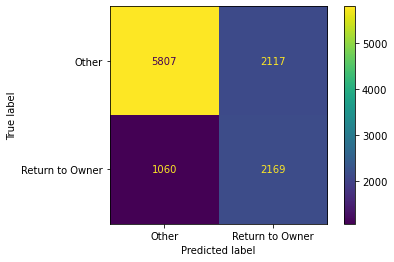

In [20]:
plot_confusion_matrix(clf, X_test, y_test);

In [21]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,intake_age_in_years,49.115218
1,breed,17.999415
2,intake_spay_neuter,17.298879
3,intake_month,8.224301
4,intake_year,7.362187


In [22]:
import shap

shap.initjs()

In [23]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test) 

In [24]:
observation_idx = 463

shap.force_plot(explainer.expected_value, shap_values[observation_idx,:], X_test.iloc[observation_idx,:])

In [25]:
observation_idx = 1800

shap.force_plot(explainer.expected_value, shap_values[observation_idx,:], X_test.iloc[observation_idx,:])

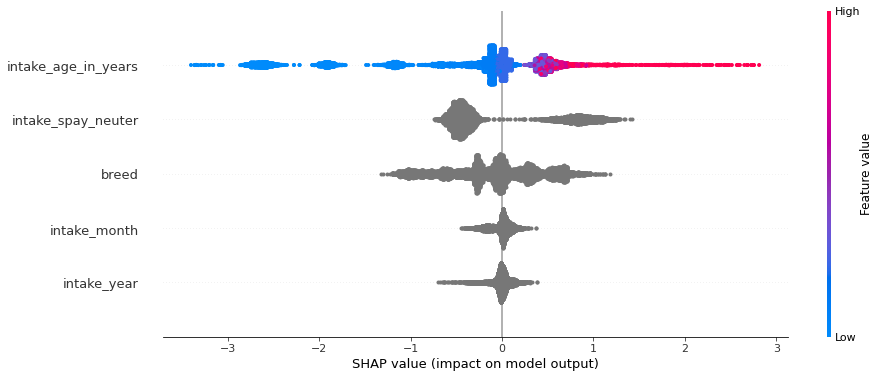

In [26]:
shap.summary_plot(shap_values, X_test, plot_size = (14,6))

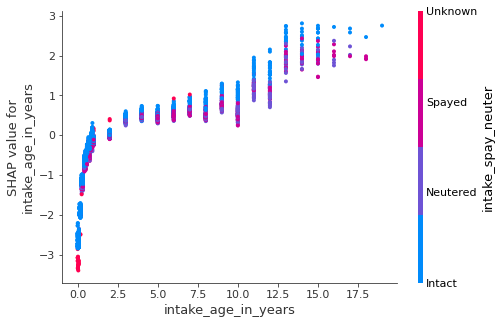

In [27]:
shap.dependence_plot('intake_age_in_years', shap_values, X_test)